<a href="https://colab.research.google.com/github/sf-rahul/Tensorflow/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting fuel efficiency


In [1]:

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
!pip install seaborn
!pip install -q git+https://github.com/tensorflow/docs

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [7]:
dataset_path = keras.utils.get_file("auto-mpg.data","http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [8]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path,names = column_names,na_values = "?",comment='\t',sep=" ",skipinitialspace=True)
dataset= raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset=dataset.dropna()


In [11]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset['Origin'] = dataset['Origin'].map(lambda x:{1:'USA',2:'Europe',3:'Japan'}.get(x))

In [13]:
dataset['Origin']

0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, Length: 392, dtype: object

In [14]:
dataset = pd.get_dummies(dataset,prefix='',prefix_sep='')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)


In [16]:
train_dataset.index

Int64Index([146, 282,  69, 378, 331, 257, 310, 328, 125, 108,
            ...
            171,  70, 307,  49, 209, 281, 229, 150, 145, 182],
           dtype='int64', length=314)

In [0]:
test_dataset = dataset.drop(train_dataset.index)

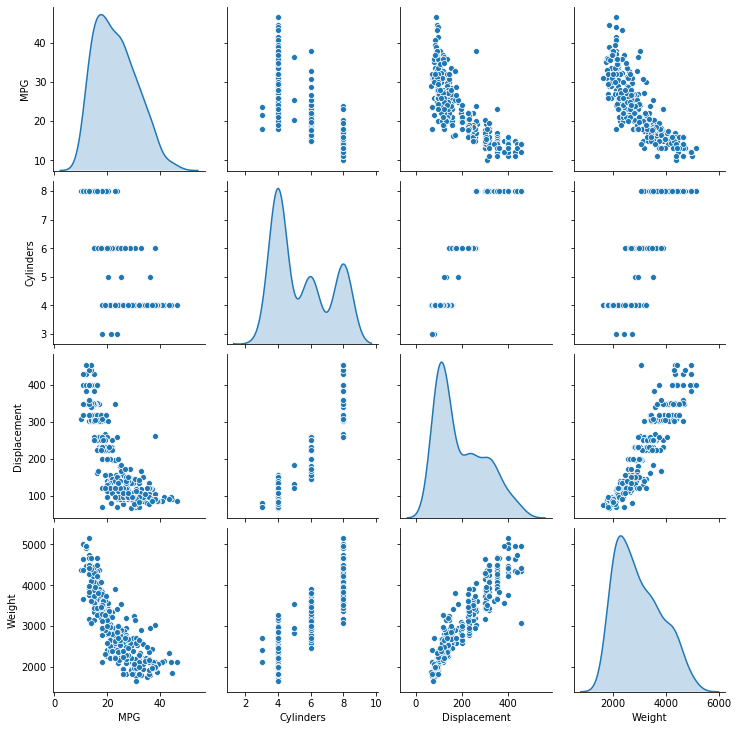

In [18]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],diag_kind='kde')

In [19]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats['mean']

Cylinders          5.477707
Displacement     195.318471
Horsepower       104.869427
Weight          2990.251592
Acceleration      15.559236
Model Year        75.898089
Europe             0.178344
Japan              0.197452
USA                0.624204
Name: mean, dtype: float64

In [0]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [0]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [22]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751


In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
    layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.01)
  model.compile(loss = 'mse',optimizer=optimizer,metrics=['mae','mse'])
  return model

In [0]:
model=build_model()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [26]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.31819826],
       [ 0.03952782],
       [-0.28999144],
       [ 0.30838707],
       [-0.02524042],
       [ 0.089001  ],
       [ 0.0461248 ],
       [-0.13295957],
       [ 0.0084903 ],
       [ 0.03709213]], dtype=float32)

In [27]:
EPOCHS = 1000
history=model.fit(normed_train_data,train_labels,epochs=EPOCHS,validation_split = 0.2,verbose=0,
                  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:223.1740,  mae:11.4892,  mse:223.1740,  val_loss:20.2266,  val_mae:3.6293,  val_mse:20.2266,  
....................................................................................................
Epoch: 100, loss:10.1141,  mae:2.3508,  mse:10.1141,  val_loss:7.6938,  val_mae:2.0653,  val_mse:7.6938,  
....................................................................................................
Epoch: 200, loss:4.1508,  mae:1.4148,  mse:4.1508,  val_loss:10.3228,  val_mae:2.4873,  val_mse:10.3228,  
....................................................................................................
Epoch: 300, loss:5.8634,  mae:1.7984,  mse:5.8634,  val_loss:12.2847,  val_mae:2.7229,  val_mse:12.2847,  
....................................................................................................
Epoch: 400, loss:4.3841,  mae:1.3641,  mse:4.3841,  val_loss:12.0371,  val_mae:2.6741,  val_mse:12.0371,  
.........................................................

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.896223,0.969204,1.896223,9.251145,2.389921,9.251145,995
996,1.682252,0.839954,1.682252,9.908588,2.426794,9.908587,996
997,1.967572,0.969620,1.967571,8.672764,2.183604,8.672764,997
998,1.365865,0.718190,1.365865,16.782001,2.893810,16.782001,998
999,2.806798,1.100163,2.806798,8.858173,2.202035,8.858172,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

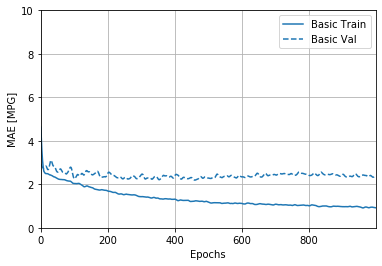

In [30]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

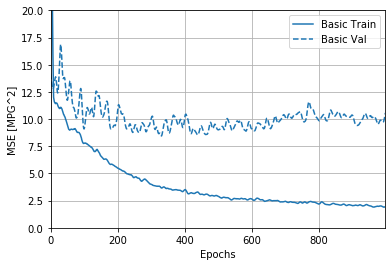

In [31]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:236.2827,  mae:12.2254,  mse:236.2827,  val_loss:22.7405,  val_mae:3.7663,  val_mse:22.7405,  
.....................

Text(0, 0.5, 'MAE [MPG]')

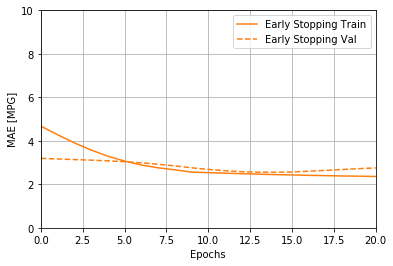

In [33]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [34]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 12.5901 - mae: 2.8765 - mse: 12.5901
Testing set Mean Abs Error:  2.88 MPG


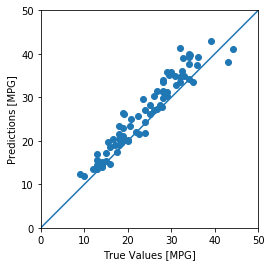

In [35]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


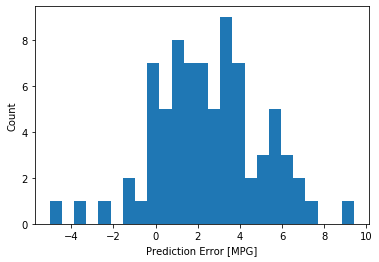

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")